# Analysis of baseline differences between ECT and MST treatment groups

## imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import corr, ttest, normality, wilcoxon
from cliffs_delta import cliffs_delta
from scipy.stats import zscore

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


---

# 1) MST

## Load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis for pre, post, and post-treatment difference. Features are averaged over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 were dropped due to poor models fits. 

In [2]:
mst_pre_post_diff = pd.read_csv('../saved_files/mst_files/mst_pre_post_diff_df.csv', index_col=0)

## Load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [3]:
MST_clinical = pd.read_csv('../saved_files/mst_files/mst_clinical_data/MST_clinical.csv')
MST_HAMD = pd.read_csv('../saved_files/mst_files/mst_clinical_data/MST_HAMD.csv')

# Rename columns
MST_HAMD = MST_HAMD[['subject', 'TotalBaseline', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                'TotalBaseline': 'pre_HAMD',
                                                                                'TotalPost': 'post_HAMD'})
MST_clinical = MST_clinical[['SubjectID', 'x_OfAcuteTxsReceived']].copy().rename(columns={'SubjectID': 'patient',
                                                                                  'x_OfAcuteTxsReceived': 'n_TxsReceived'})

# Merge into single dataframe
all_clinical = pd.merge(MST_HAMD, MST_clinical, on='patient', how='outer')

In [4]:
# Merge spectral features dataframe with clinical features dataframe
mst_clin_eeg_df = pd.merge(mst_pre_post_diff, all_clinical, on='patient', how='left')

---
# 2) ECT

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [5]:
ect_pre_post_diff = pd.read_csv('../saved_files/ect_files/ect_pre_post_diff_df.csv', index_col=0)

## Load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [6]:
ECT_clinical = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_HAMD.csv')

# Rename columns
ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# Merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_clinical, on='patient', how='outer')

In [7]:
# Merge spectral features dataframe with clinical features dataframe
ect_clin_eeg_df = pd.merge(ect_pre_post_diff, all_clinical, on='patient', how='left')

----

# 3)ECT & MST

In [8]:
# Add treatment type column
mst_clin_eeg_df['treatment_type'] = np.tile('MST', len(mst_clin_eeg_df['patient']))
ect_clin_eeg_df['treatment_type'] = np.tile('ECT', len(ect_clin_eeg_df['patient']))

In [9]:
ect_mst_clin_eeg_df = pd.concat([ect_clin_eeg_df, mst_clin_eeg_df], ignore_index=True)

In [10]:
ect_mst_clin_eeg_df.head()

,patient,pre_exponent,pre_offset,pre_delta_amp,pre_delta_bp,pre_theta_amp,pre_theta_bp,pre_theta_cf,pre_delta_cf,pre_alpha_amp,...,diff_alpha_amp,diff_alpha_bp,diff_alpha_cf,diff_ch_theta_perc,diff_ch_delta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type
0,3,0.475478,-11.985471,0.110521,-12.143266,0.283711,-12.224720,6.654823,1.471049,0.832821,...,0.275602,-0.286402,0.081001,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT
1,4,0.810115,-11.540574,0.210006,-11.752841,0.290177,-12.230327,5.305208,2.387229,1.476136,...,0.476360,0.772309,0.813718,-0.816667,-0.033333,0.000000,24.0,13.0,10.0,ECT
2,10,0.902232,-11.672074,0.082965,-11.983244,0.229451,-12.161033,5.749715,3.434821,1.123810,...,-0.338883,-0.726749,1.695905,-0.283333,0.116667,0.000000,21.0,20.0,11.0,ECT
3,13,1.015031,-11.609259,0.151263,-11.884587,0.370829,-12.171802,6.155017,2.084118,1.464451,...,0.100156,-0.051523,0.028742,-0.166667,-0.016667,0.000000,25.0,22.0,15.0,ECT
4,16,0.809859,-11.699310,NaN,-12.021677,0.213585,-12.270817,5.831488,NaN,0.956072,...,0.124481,-0.211126,1.022784,-0.316667,-0.133333,0.000000,24.0,NaN,14.0,ECT


## Standardize HAMD scores and save new dataframe

In [19]:
# Standardize HAMD scores from either rating (HAMD-17 or HAMD-24)
MAX_HAMD_17 = 52
MAX_HAMD_24 = 76

ect_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['pre_HAMD']
std_ect_HAMD_pre = (ect_HAMD_pre-0)/(MAX_HAMD_17-0)

ect_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['post_HAMD']
std_ect_HAMD_post = (ect_HAMD_post-0)/(MAX_HAMD_17-0)

mst_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['pre_HAMD']
std_mst_HAMD_pre = (mst_HAMD_pre-0)/(MAX_HAMD_24-0)

mst_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['post_HAMD']
std_mst_HAMD_post = (mst_HAMD_post-0)/(MAX_HAMD_24-0)

In [20]:
# Concatenate HAMD standardized scores
std_HAMD_pre = pd.concat([std_ect_HAMD_pre, std_mst_HAMD_pre])
std_HAMD_post = pd.concat([std_ect_HAMD_post, std_mst_HAMD_post])
# Label which is pre and post
ect_mst_clin_eeg_df['std_HAMD_pre'] = std_HAMD_pre
ect_mst_clin_eeg_df['std_HAMD_post'] = std_HAMD_post

In [21]:
# Eliminate participants that have no HAMD score
ect_mst_clin_eeg_df_nonan = pd.DataFrame(ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['std_HAMD_post'].notna()])

In [22]:
ect_mst_clin_eeg_df_nonan.head()

,patient,pre_exponent,pre_offset,pre_delta_amp,pre_delta_bp,pre_theta_amp,pre_theta_bp,pre_theta_cf,pre_delta_cf,pre_alpha_amp,...,diff_alpha_cf,diff_ch_theta_perc,diff_ch_delta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type,std_HAMD_pre,std_HAMD_post
0,3,0.475478,-11.985471,0.110521,-12.143266,0.283711,-12.224720,6.654823,1.471049,0.832821,...,0.081001,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT,0.634615,0.134615
1,4,0.810115,-11.540574,0.210006,-11.752841,0.290177,-12.230327,5.305208,2.387229,1.476136,...,0.813718,-0.816667,-0.033333,0.000000,24.0,13.0,10.0,ECT,0.461538,0.250000
2,10,0.902232,-11.672074,0.082965,-11.983244,0.229451,-12.161033,5.749715,3.434821,1.123810,...,1.695905,-0.283333,0.116667,0.000000,21.0,20.0,11.0,ECT,0.403846,0.384615
3,13,1.015031,-11.609259,0.151263,-11.884587,0.370829,-12.171802,6.155017,2.084118,1.464451,...,0.028742,-0.166667,-0.016667,0.000000,25.0,22.0,15.0,ECT,0.480769,0.423077
5,18,0.880447,-11.752390,NaN,-12.055804,NaN,-12.413767,NaN,NaN,0.467704,...,0.645287,-0.466667,-0.050000,0.133333,23.0,30.0,17.0,ECT,0.442308,0.576923


# Pre/Post Clinical Scores

In [23]:
def plot_feature_prepost(exp_df_mean, feature='', tx_type=''):
    """Creates a plot of a given feature from the dataframe,
       comparing its value before and after treatment

    Parameters
    ----------
    exp_df_mean: pandas DataFrame
        dataframe containing extractec features, averaged across electrodes
    feature: str
        feature of interest; 'alphas', 'thetas', 'chans_exps'
    tx_type: str
        treatment type (to determine color scheme); 'ECT', 'MST'

    Returns
    -------
    plot: matplotlib obj
        plot of feature pre/post treatment
    """
    
    pats = np.unique(exp_df_mean['patient'])
    
    if tx_type=='ECT':
        pre_color = 'orange'
        post_color = 'teal'
    elif tx_type=='MST':
        pre_color = 'royalblue'
        post_color = 'salmon'

    # means of alphas across patient, channels
    means_pre = exp_df_mean['pre_HAMD'].values
    means_post = exp_df_mean['post_HAMD'].values

    sns.set_context('poster')

    plt.figure(figsize=(5,8))
    x1, x2 = 0.5, 1.5

    for pat in pats:

        point_pre = exp_df_mean[(exp_df_mean['patient']==pat)]['pre_HAMD'].values
        point_post = exp_df_mean[(exp_df_mean['patient']==pat)]['post_HAMD'].values
        xdat1= x1+np.random.normal(0, 0.025, 1)
        xdat2= x2+np.random.normal(0, 0.025, 1)


        plt.plot([xdat1,xdat2], [point_pre, point_post], color='k', alpha=0.05, lw=5)
        plt.scatter(xdat1, point_pre, color=pre_color, alpha=0.7)
        plt.scatter(xdat2, point_post, color=post_color, alpha=0.7)

    plt.plot([x1-0.2, x1+0.2], [np.nanmean(means_pre), np.nanmean(means_pre)], lw=7, c=pre_color)
    plt.plot([x2-0.2, x2+0.2], [np.nanmean(means_post), np.nanmean(means_post)], lw=7, c=post_color)
    plt.xlim([0, 2])
    plt.xticks([x1, x2], ["pre", "post"])
    plt.tight_layout()

In [24]:
# Plot for ECT
ect_df_nonan = ect_mst_clin_eeg_df_nonan[ect_mst_clin_eeg_df_nonan['treatment_type']=='ECT']

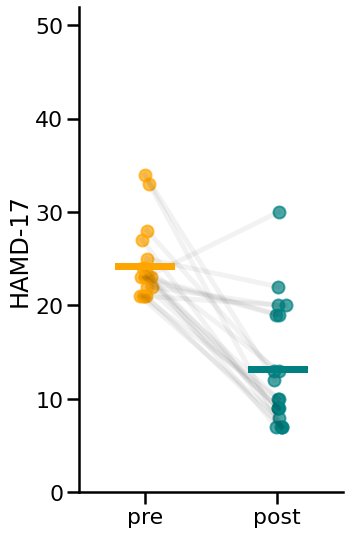

In [25]:
plot_feature_prepost(ect_df_nonan, feature='pre_HAMD', tx_type='ECT')
plt.ylabel('HAMD-17');
plt.ylim([0,52])
sns.despine()

Statistics

In [26]:
print('pre = '+ str(ect_df_nonan['pre_HAMD'].mean())\
      + ' std = ' + str(ect_df_nonan['pre_HAMD'].std()))

print('post = '+ str(ect_df_nonan['post_HAMD'].mean())\
      + ' std = ' + str(ect_df_nonan['post_HAMD'].std()))

pre = 24.263157894736842 std = 3.7689094394231737
post = 13.210526315789474 std = 6.562341616022448


In [27]:
normality(ect_df_nonan[['pre_HAMD', 'post_HAMD']])

,W,pval,normal
pre_HAMD,0.766256,0.000385,False
post_HAMD,0.849770,0.006651,False


In [28]:
wilcoxon(ect_df_nonan['pre_HAMD'], ect_df_nonan['post_HAMD'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,6.0,two-sided,0.000053,0.936842,0.939058


In [29]:
cliffs_delta(ect_df_nonan['pre_HAMD'], ect_df_nonan['post_HAMD'])

(0.8781163434903048, 'large')

In [30]:
ect_df_nonan[['pre_HAMD', 'post_HAMD']].describe()

,pre_HAMD,post_HAMD
count,19.000000,19.000000
mean,24.263158,13.210526
std,3.768909,6.562342
min,21.000000,7.000000
25%,22.000000,8.500000
50%,23.000000,10.000000
75%,24.500000,19.000000
max,34.000000,30.000000


In [31]:
# Plot for MST
mst_df_nonan = ect_mst_clin_eeg_df_nonan[ect_mst_clin_eeg_df_nonan['treatment_type']=='MST']

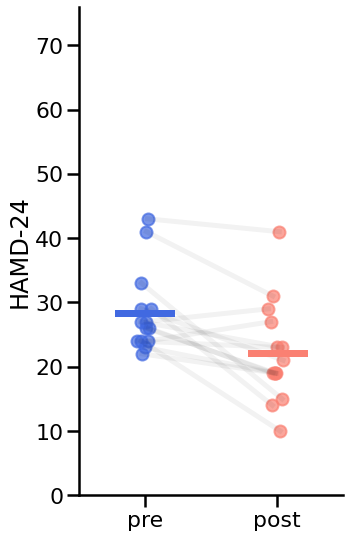

In [32]:
plot_feature_prepost(mst_df_nonan, feature='pre_HAMD', tx_type='MST')
plt.ylabel('HAMD-24');
plt.ylim([0,76])
sns.despine()

In [33]:
normality(mst_df_nonan[['pre_HAMD', 'post_HAMD']])

,W,pval,normal
pre_HAMD,0.807431,0.006176,False
post_HAMD,0.940928,0.430341,True


In [34]:
wilcoxon(mst_df_nonan['pre_HAMD'], mst_df_nonan['post_HAMD'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,7.0,two-sided,0.002319,0.866667,0.772959


In [35]:
cliffs_delta(mst_df_nonan['pre_HAMD'], mst_df_nonan['post_HAMD'])

(0.5459183673469388, 'large')

In [36]:
mst_df_nonan[['pre_HAMD', 'post_HAMD']].describe()

,pre_HAMD,post_HAMD
count,14.000000,14.000000
mean,28.428571,22.142857
std,6.429670,7.901871
min,22.000000,10.000000
25%,24.000000,19.000000
50%,26.500000,20.000000
75%,29.000000,26.000000
max,43.000000,41.000000


# Mutliple linear regression with combined data

## Exhaustive Search for Regression

In [37]:
features = ['pre_exponent', 
            'pre_ch_delta_perc', 'pre_ch_theta_perc',
            'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'n_TxsReceived', 'treatment_type_ECT',
            'std_HAMD_pre']

In [38]:
ect_mst_clin_eeg_df['treatment_type_ECT'] = pd.get_dummies(ect_mst_clin_eeg_df['treatment_type'], dtype=float)['ECT'].values

In [39]:
nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_2602/116426721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])


In [40]:
ect_mst_dict = {'data': nonan_df[features].values,
                'target': nonan_df['std_HAMD_post'].values,
                'target_names': ['std_HAMD_post'],
                'feature_names': features}

In [42]:
X = ect_mst_dict['data']
y = ect_mst_dict['target']

lr = LinearRegression()

efs = EFS(lr, 
          min_features=3,
          max_features=9,
          fixed_features=(7,8),
          scoring='neg_mean_squared_error',
          cv=10)

efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 127/127


Best subset: (0, 7, 8)


In [43]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [44]:
for i in efs.subsets_:
    efs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=efs.subsets_[i]['avg_score'],
                  num_examples=X.shape[0]/10,
                  num_features=len(efs.subsets_[i]['feature_idx']))
    )

In [45]:
score = -99e10

for i in efs.subsets_:
    score = efs.subsets_[i]['adjusted_avg_score']
    if ( efs.subsets_[i]['adjusted_avg_score'] == score and
        len(efs.subsets_[i]['feature_idx']) < len(efs.best_idx_) )\
      or efs.subsets_[i]['adjusted_avg_score'] > score:
        efs.best_idx_ = efs.subsets_[i]['feature_idx']

In [46]:
print('Best adjusted R2 score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)


Best subset: (0, 7, 8)


In [47]:
# standardized beta coefficients 
features = ['std_HAMD_post', 'std_HAMD_pre', 'pre_exponent', 'treatment_type']

# standardizing dataframe
df_z = ect_mst_clin_eeg_df[features].dropna()
df_z_2 = df_z.select_dtypes(include=np.number).apply(zscore)
df_z_2['treatment_type'] = df_z['treatment_type']

# multiple linear regression
model = ols('std_HAMD_post ~ std_HAMD_pre + pre_exponent + C(treatment_type)', df_z_2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          std_HAMD_post   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.411
Date:                Thu, 19 Oct 2023   Prob (F-statistic):              0.260
Time:                        10:24:55   Log-Likelihood:                -44.578
No. Observations:                  33   AIC:                             97.16
Df Residuals:                      29   BIC:                             103.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [48]:
# Correcting for heteroskedasticity
model.get_robustcov_results(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          std_HAMD_post   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.282
Date:                Thu, 19 Oct 2023   Prob (F-statistic):              0.299
Time:                        10:24:56   Log-Likelihood:                -44.578
No. Observations:                  33   AIC:                             97.16
Df Residuals:                      29   BIC:                             103.1
Df Model:                           3                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.1694      0.301     -0.562      0.578      -0.786       0.447
C(treatment_type)[T.MST]     0.3994      0.514      0.777      0.444      -0.652       1.451
std_HAMD_pre                 0.2482      0.258      0.963      0.344      -0.279       0.775
pre_exponent                 0.3003      0.172      1.749      0.091      -0.051       0.651
==============================================================================
Omnibus:                        7.605   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.193
Skew:                           1.010   Prob(JB):                       0.0452
Kurtosis:                       3.654   Cond. No.                         3.27
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

eval_env: 1


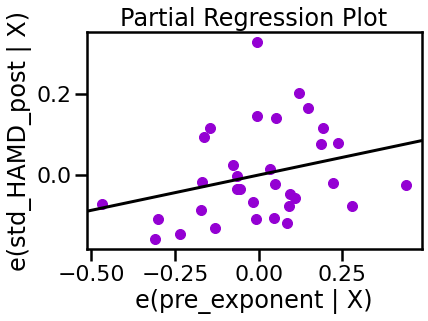

In [51]:
_, coords = sm.graphics.plot_partregress(endog="std_HAMD_post", exog_i="pre_exponent", exog_others=["std_HAMD_pre", 'C(treatment_type)'],
                             data=ect_mst_clin_eeg_df_nonan, obs_labels=False, color='darkviolet', markersize=10, ret_coords=True);

In [52]:
# Extract coordinates from partial regression plot
ect_mst_clin_eeg_df_nonan['coord_x'] = coords[0]
ect_mst_clin_eeg_df_nonan['coord_y'] = coords[1]

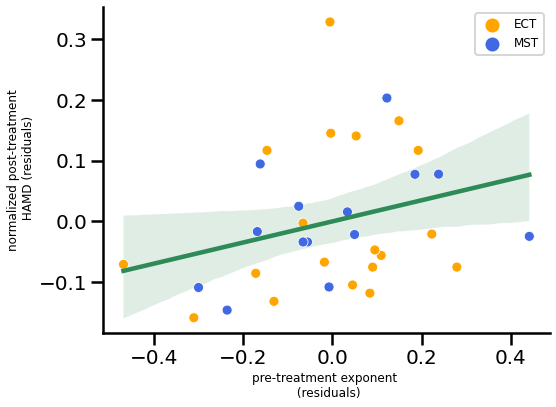

In [55]:
color_dict = {'ECT':'orange',
              'MST': 'royalblue'}
fig,ax = plt.subplots(figsize=(8,6))
sns.regplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', color='seagreen', scatter=False)
sns.scatterplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', hue='treatment_type',
                palette=color_dict, s=100)

plt.xlabel('pre-treatment exponent \n (residuals)', size=12)
plt.ylabel('normalized post-treatment\n HAMD (residuals)', size=12)
ax.tick_params(axis='both', labelsize=20)
plt.legend(title='', fontsize=12)
sns.despine()
plt.show()

# Supplemental Analyses 
### Difference in baseline exponent ECT & MST 

In [56]:
ttest(mst_clin_eeg_df['pre_exponent'], ect_clin_eeg_df['pre_exponent'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.711729,42,two-sided,0.094323,"[-0.02, 0.22]",0.516106,0.951,0.387057


In [57]:
print(normality(mst_clin_eeg_df['pre_exponent']))
print(normality(ect_clin_eeg_df['pre_exponent']))

                     W      pval  normal
pre_exponent  0.961918  0.528998    True
                     W      pval  normal
pre_exponent  0.971783  0.751975    True


In [58]:
mst_clin_eeg_df['pre_exponent'].describe()

count    22.000000
mean      0.978943
std       0.182696
min       0.632349
25%       0.862424
50%       0.956634
75%       1.076650
max       1.473953
Name: pre_exponent, dtype: float64

In [59]:
ect_clin_eeg_df['pre_exponent'].describe()

count    22.000000
mean      0.877277
std       0.210306
min       0.427745
25%       0.744020
50%       0.925695
75%       0.999571
max       1.291168
Name: pre_exponent, dtype: float64

Text(0.5, 0, 'baseline exponent')

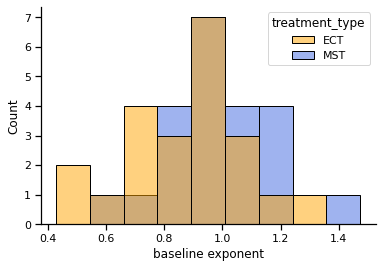

In [60]:
sns.set_context('notebook')
color_dict = {'ECT':'orange',
              'MST': 'royalblue'}

plt.figure(figsize=[6,4])
sns.histplot(ect_mst_clin_eeg_df, x='pre_exponent', hue='treatment_type', palette=color_dict)
sns.despine()
plt.xlabel('baseline exponent')

### Relationship between difference in exponent and number of treatments received

**ECT**

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(11.25, 0.5, '$\\Delta$ exponent')

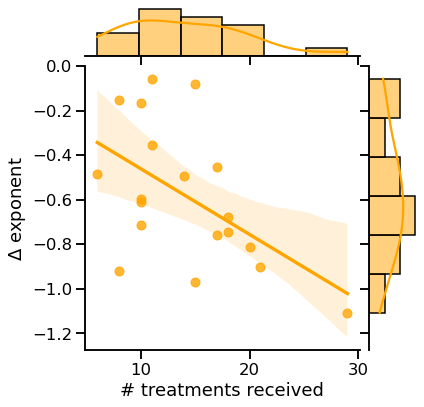

In [61]:
sns.set_context('talk')

x = ect_clin_eeg_df['n_TxsReceived']
y = ect_clin_eeg_df['diff_exponent']

h = sns.jointplot(x, y, kind="reg", color='orange')
h.ax_joint.set_xlabel('# treatments received')
h.ax_joint.set_ylabel('$\Delta$ exponent')

In [62]:
corr(x,y)

,n,r,CI95%,p-val,BF10,power
pearson,19,-0.536577,"[-0.8, -0.11]",0.017858,3.865,0.688058


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(11.25, 0.5, '$\\Delta$ exponent')

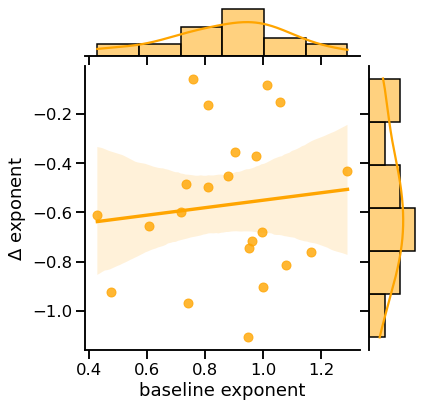

In [63]:
x = ect_clin_eeg_df['pre_exponent']
y = ect_clin_eeg_df['diff_exponent']

h = sns.jointplot(x, y, kind="reg", color='orange')
h.ax_joint.set_xlabel('baseline exponent')
h.ax_joint.set_ylabel('$\Delta$ exponent')

In [64]:
corr(x,y)

,n,r,CI95%,p-val,BF10,power
pearson,22,0.108111,"[-0.33, 0.51]",0.632015,0.294,0.076375


**MST**

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(11.25, 0.5, '$\\Delta$ exponent')

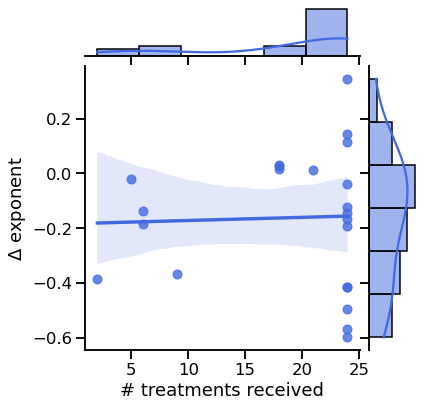

In [65]:
x = mst_clin_eeg_df['n_TxsReceived']
y = mst_clin_eeg_df['diff_exponent']

h = sns.jointplot(x, y, kind="reg", color='royalblue')
h.ax_joint.set_xlabel('# treatments received')
h.ax_joint.set_ylabel('$\Delta$ exponent')

In [66]:
corr(x,y)

,n,r,CI95%,p-val,BF10,power
pearson,22,0.035919,"[-0.39, 0.45]",0.873913,0.267,0.052245


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(11.25, 0.5, '$\\Delta$ exponent')

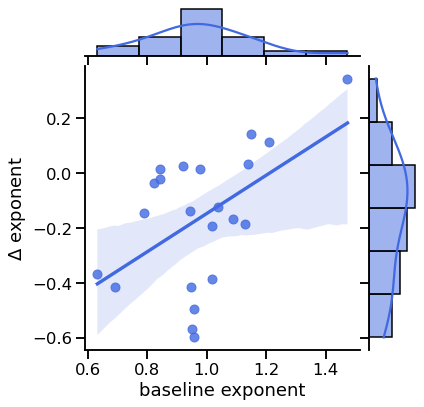

In [67]:
x = mst_clin_eeg_df['pre_exponent']
y = mst_clin_eeg_df['diff_exponent']

h = sns.jointplot(x, y, kind="reg", color='royalblue')
h.ax_joint.set_xlabel('baseline exponent')
h.ax_joint.set_ylabel('$\Delta$ exponent')

In [68]:
corr(x,y)

,n,r,CI95%,p-val,BF10,power
pearson,22,0.514236,"[0.12, 0.77]",0.014348,4.413,0.714121
